In [14]:
import os
from langgraph.graph import StateGraph , START, END
from typing import TypedDict , Dict, List, Annotated
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from IPython.display import display,Image

os.environ["GROQ_API_KEY"] = "your_api_key"
model="meta-llama/llama-4-scout-17b-16e-instruct"

In [15]:
llm = ChatGroq(model=model)

In [16]:
class PlannerState(TypedDict):
    messages : Annotated[List[HumanMessage | AIMessage],"The messages in the conversation."]
    city:str
    interests:str
    itinerary:str

In [17]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human" , "Create an itinerary for my day trip.")
])
chain = itinerary_prompt |llm

In [28]:
def input_city(state:PlannerState)->PlannerState:
    print("Please enter the city you want to visit for your day trip: ")
    user_message = input("Your input:")
    return{
        **state,
        "city":user_message,
        "messages" : state["messages"]+[HumanMessage(content=user_message)],
    }

def input_interesets(state : PlannerState)->PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return{
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages" : state["messages"] +[HumanMessage(content=user_message)],
    }

def create_itinerary(state:PlannerState)->PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = chain.invoke({"city":state["city"],"interests" : ", ".join(state["interests"])}).content
    print("\nFinal Itınerary: ")
    print(response)
    return{
        **state,
        "messages":state["messages"]+[AIMessage(content=response)],
        "itinerary" : response,
    }

In [29]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city",input_city)
workflow.add_node("input_interests",input_interesets)
workflow.add_node("create_itinerary",create_itinerary)

workflow.add_edge(START,"input_city")
workflow.add_edge("input_city","input_interests")
workflow.add_edge("input_interests","create_itinerary")
workflow.add_edge("create_itinerary",END)

app = workflow.compile()

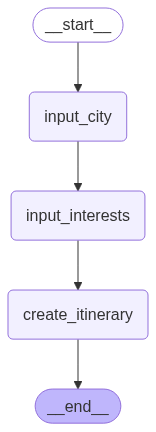

In [30]:
display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [31]:
def run_travel_planner(user_request:str):
    print(f"Initial Requests: {user_request}\n")
    state={
        "messages" : [HumanMessage(content=user_request)],
        "city":"",
        "interests":[],
        "itinerary":"",
    }
    for output in app.stream(state):
        pass

In [32]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Requests: I want to plan a day trip.

Please enter the city you want to visit for your day trip: 


Your input: from ankara to gaziantep


Please enter your interests for the trip to from ankara to gaziantep (comma-separated):


Your input:  eating, swimming, cultural places


Creating an itinerary for from ankara to gaziantep based on interests: eating, swimming, cultural places...

Final Itınerary: 
Here's a suggested day trip itinerary from Ankara to Gaziantep based on your interests:

* **8:00 AM - Departure from Ankara**: Take an early morning bus or drive to Gaziantep (approximately 6-7 hours).
* **2:00 PM - Lunch**: Head to the city center and try some of Gaziantep's famous kebabs and baklava at a local restaurant, such as:
	+ Kebapçı İmam: Known for their delicious kebabs.
	+ Baklava Sarayı: Try their traditional Gaziantep-style baklava.
* **3:30 PM - Gaziantep Zoo and Atatürk Park**: Visit the Gaziantep Zoo, which is home to over 1,000 animals from around the world. Afterward, take a stroll through the adjacent Atatürk Park, a beautiful green oasis in the city.
* **5:30 PM - Swimming**: Head to the Gaziantep Aquapark, a modern water park with various pools, water slides, and a wave pool.
* **8:00 PM - Dinner**: Try some more local cuisine, such as:
